# Introduction

This is an unsupervised learning algorithm which partitions the observations into $k$ clusters where each point belongs to a cluster with nearest mean (nearness metric can vary, but usually set to euclidean distance). More formally, given a set of $n$ observation vectors, this algorithm tries to generate $k$ clusters so as to minimize the within-cluster sum of squares (WCSS). The most common implementation is a heuristic algorithm which greedily tries to cluster the points and improve on it. This is not bound to reach the optimal solution but usually does well. To write in steps:
    1. Initialize k random points to be the centroids of clusters
    2. Assign all observation points to some cluster based on the distance metric
    4. Calculate the new centroids from this newly formed clusters
    5. Repeat steps 2 and 4 until some stoppping criteria is reached
The initialization step can be done in many ways actually. One way is to randomly select $k$ points as mean. Another can be to randomly assign each point to some cluster, and then calculate the mean of the clusters ( step 4 ).
This algorithm has some limitations which can be read <a href="https://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means/133841#133841">here</a>.

# K-means in python

We just code the above steps. For stopping criteria we see if the squared sum distance between corresponding centroids have decreased above a threshold. We also set a hard maximum number of iterations we allow the algorithm to run. Also, we have a parameter which decides how many times the complete algo is run for different random initializations. This is to ensure we don't conclude bad clusters due to some skewed initializations of centroids.

In [43]:
import numpy as np
import random
import math

class KMeansCluster:
    
    # numClusters: the clusters to form
    # maxIters: the maximum iterations for clustering
    #tolerance: the tolerance after which clustering stops (uses intertia of centroid)
    #nInits: the number of times the algorithm is run for different initializations
    def __init__(self, numClusters=2, maxIters=100, tolerance=None, nInits=5):
        self.numClusters = numClusters
        self.maxIters = maxIters
        self.tolerance = tolerance
        self.nInits = nInits
        self.centroids = []    # stores the current centroid values (k centroids)
        self.labels = []   # stores the cluster label for given set of observations (n labels)
        self.numIters = 0              # number of iterations of clustering
        self.error = float('inf')      # the error being reduced (used to stop after tolerace is reached)
        self.results = {}              # stores results from each iteration (key is wcss value)
    
    def __clear(self):
        self.centroids = []
        self.labels = []
        self.numIters = 0
        self.error = float('inf')

    def __euclidean(self, X, Y):
        # given vectors X and Y returns the euclidean distance
        return math.sqrt(np.sum(np.square(X - Y)))
    
    def __labelSamples(self, X):
        # given the samples and the mean values, sets the labels for each sample
        self.labels = [np.argmin([self.__euclidean(x, y) for y in self.centroids]) for x in X]
    
    def __updateClusterMean(self, X):
        # tries to update the means for the current set of labels
        self.centroids = [X[[idx for idx, val in enumerate(self.labels) if val == k ],:].mean(axis=0) for k in range(self.numClusters)]

    def __wcss(self, X):
        # Within-cluster sum of squares
        return sum(self.__euclidean(x, self.centroids[self.labels[idx]]) for idx, x in enumerate(X))
    
    def __inertiaShift(self, oldCentroids):
        return sum([self.__euclidean(self.centroids[k], oldCentroids[k]) for k in range(self.numClusters) ])

    def __fitHelper(self, X):
        if self.numIters == 0:
            # initialize centroids with random samples
            self.centroids = X[np.random.randint(X.shape[0], size=self.numClusters), :]
        self.__labelSamples(X)
        if (self.tolerance is not None and self.error <= self.tolerance) or self.numIters >= self.maxIters:
            self.results[self.score(X)] = [np.array(self.labels), np.array(self.centroids), self.numIters]
            self.__clear()
        else:
            self.numIters += 1
            oldCentroids = self.centroids
            self.__updateClusterMean(X)
            self.error = self.__inertiaShift(oldCentroids)
            return self.__fitHelper(X)
    
    def fit(self, X):
        while self.nInits:
            self.__fitHelper(X)
            self.nInits -= 1
        #restore the results for the best one found
        [self.labels, self.centroids, self.numIters] = self.results[min(self.results)]
        return [self.labels, self.centroids, self.numIters] #self.results

    def predict(self, X):
        self.__labelSamples(X)
        return np.array(self.labels)
    
    def score(self, X):
        return self.__wcss(X)

Total Iterations:  14
Train score:  675.1591596583913


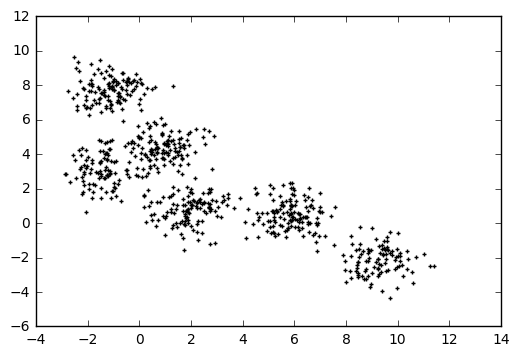

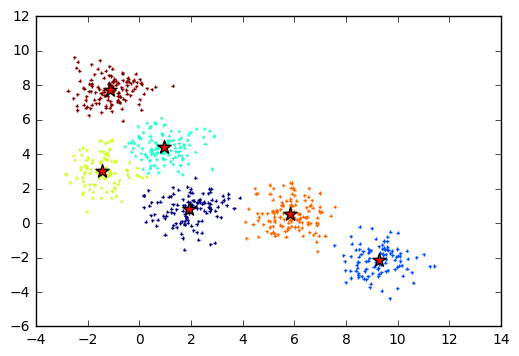

Test score:  295.46288851372714


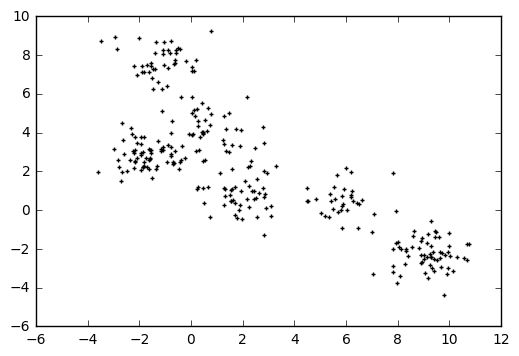

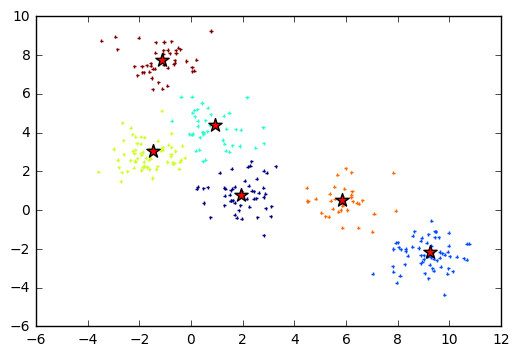

In [50]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot as plt

def randomSampleGenerator(n, numClusters):
    X, Y = make_blobs(n_samples=n, centers=numClusters,
                      random_state=0, cluster_std=0.8)
    return [X, Y]

#Given X, Y and predicted coeff, try to plot the graph of the same
def plotKMeans(X, Y, labels, centroids):
    plt.scatter(X[:,0], X[:,1], c='black', s=5, marker='+')
    plt.show()
    plt.scatter(X[:,0], X[:,1], c=labels, s=5, marker='+')
    plt.scatter(centroids[:,0], centroids[:,1], s=100, c='r', marker='*')
    plt.show()

numSamples = 1000
numClusters = 6
[X, Y] = randomSampleGenerator(numSamples, numClusters)
[XTrain, YTrain] = [X[0:int(0.7*numSamples),:], Y[0:int(0.7*numSamples)]]
[XTest, YTest] = [X[int(0.7*numSamples):numSamples,:], Y[int(0.7*numSamples):numSamples]]
KMeans = KMeansCluster(numClusters=numClusters, maxIters=200, tolerance=0.0001, nInits=10)
[trainLabels, centroids, numIters] = KMeans.fit(XTrain)
print('Total Iterations: ', numIters)
print('Train score: ', KMeans.score(XTrain))
plotKMeans(XTrain, YTrain, trainLabels, centroids)
testLabels = KMeans.predict(XTest)
print('Test score: ', KMeans.score(XTest))
plotKMeans(XTest, YTest, testLabels, centroids)

# To see all the different 'clusters' the algorithm learns, uncomment the below section.
# This can give insight on the shortcomings of this algorithm. Also note, to make the below
# work, you'd need to change the return value of fit() function to self.results (instead of the array)

# results = KMeans.fit(XTrain)
# print(len(results))
# idx = 0
# for key, val in results.items():
#     [trainLabels, centroids, numIters] = val
#     print('WCSS for initialization ', idx, ': ', key)
#     plotKMeans(XTrain, YTrain, trainLabels, centroids)
#     idx += 1